In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from functools import partial, reduce
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from scipy.signal import savgol_filter
from numpy.fft import fft, ifft, fftfreq
from robust_pde_diff import DLrSR, RobustPCA, DLrSR_para
from para_UBIC import *
from best_subset import *
from solvel0 import solvel0

from findiff import FinDiff
from abess.linear import LinearRegression
from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.utils.random import sample_without_replacement
from UBIC import fit_blr, UBIC, decreasing_values_indices
# from skscope_tools import best_subset_all_solutions, abess_all_solutions

from tqdm import tqdm

from pysr import PySRRegressor
import feyn
from sympy import latex

fontsize = 20 # for plots

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
Best-subset solvers are NOT installed.
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
This version of feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at `https://abzu.ai/eula`.


In [2]:
def ks_rhs(u, t, params):
    k, L, x = params
    a = (1 + 0.25*np.sin(x*2*np.pi/L))  # uu_x
    b = -1 + 0.25*np.exp(-(x-2)**2/5)   # u_{xx}
    c = -1 - 0.25*np.exp(-(x+2)**2/5)   # u_{xxxx}
    deriv = a*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u)) + c*ifft(k**4*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 512
m = 512
L = 20
max_time = 200

# Set up grid
x = np.linspace(-L,L,n+1)[:-1]; dx = x[1]-x[0]
t = np.linspace(0,max_time,2*m); dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2)

# Solve with time dependent uu_x term
params = (k,L,x)
# u_full = odeint(ks_rhs, u0, t, args=(params,)).T
u_full = np.load("./Datasets/ks_u_full.npy")

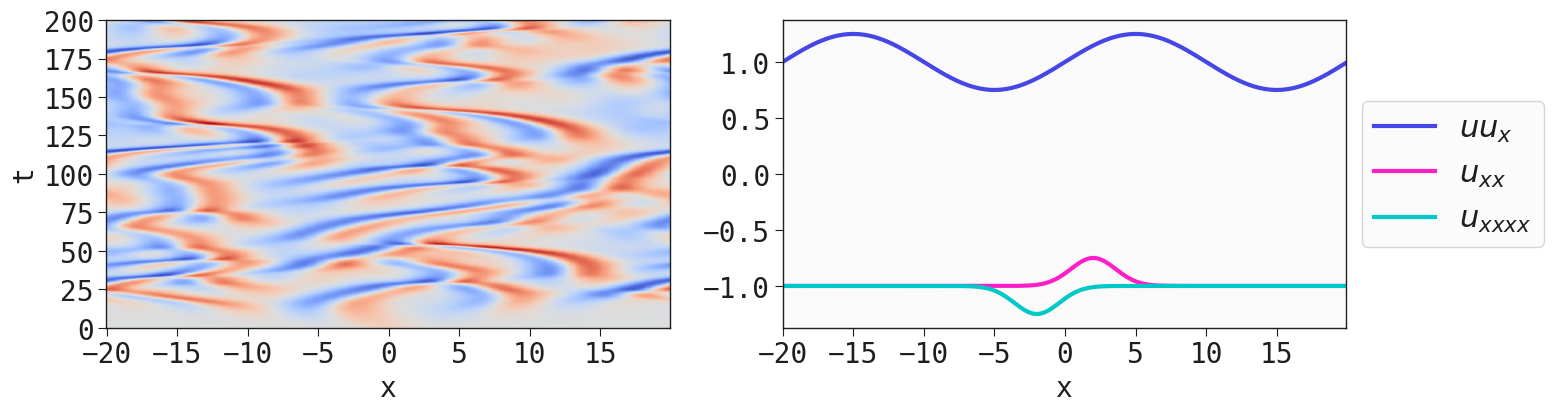

In [4]:
# Plot
fig = figure(figsize=(16, 4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u_full.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

uu_x_true = 1 + 0.25*np.sin(x*2*np.pi/L)
u_xx_true = -1 + 0.25*np.exp(-(x-2)**2/5)
u_4x_true = -1 - 0.25*np.exp(-(x+2)**2/5)

subplot(1,2,2)
plot(x, uu_x_true, label = r'$uu_x$')
plot(x, u_xx_true, label = r'$u_{xx}$')
plot(x, u_4x_true, label = r'$u_{xxxx}$')
xlim([x[0],x[-1]])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
# u = u_full[:,-m:]
# t = t[-m:]
u = u_full[:,:m]
t = t[:m]

In [6]:
noise_lv = 0.01
np.random.seed(0)
u = u + noise_lv*0.01*std(u)*np.random.randn(n,m)

is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=0)

alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=False)

In [7]:
# # Build linear systems
# wx = 10
# wt = 10
# deg_x = 6
# deg_t = 4

# Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
#                                        deg_x = deg_x, deg_t = deg_t, 
#                                        width_x = wx, width_t = wt)
# n2 = n - 2*wx
# m2 = m - 2*wt

# Theta_grouped = np.array([real(Theta[n*np.arange(m)+j,:]) for j in range(n)])
# Ut_grouped = np.array([real(Ut[n*np.arange(m)+j]) for j in range(n)])

fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(Theta_grouped.shape[-1])])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

4 u_xx
5 u_xxx
6 u_xxxx
7 uu_x


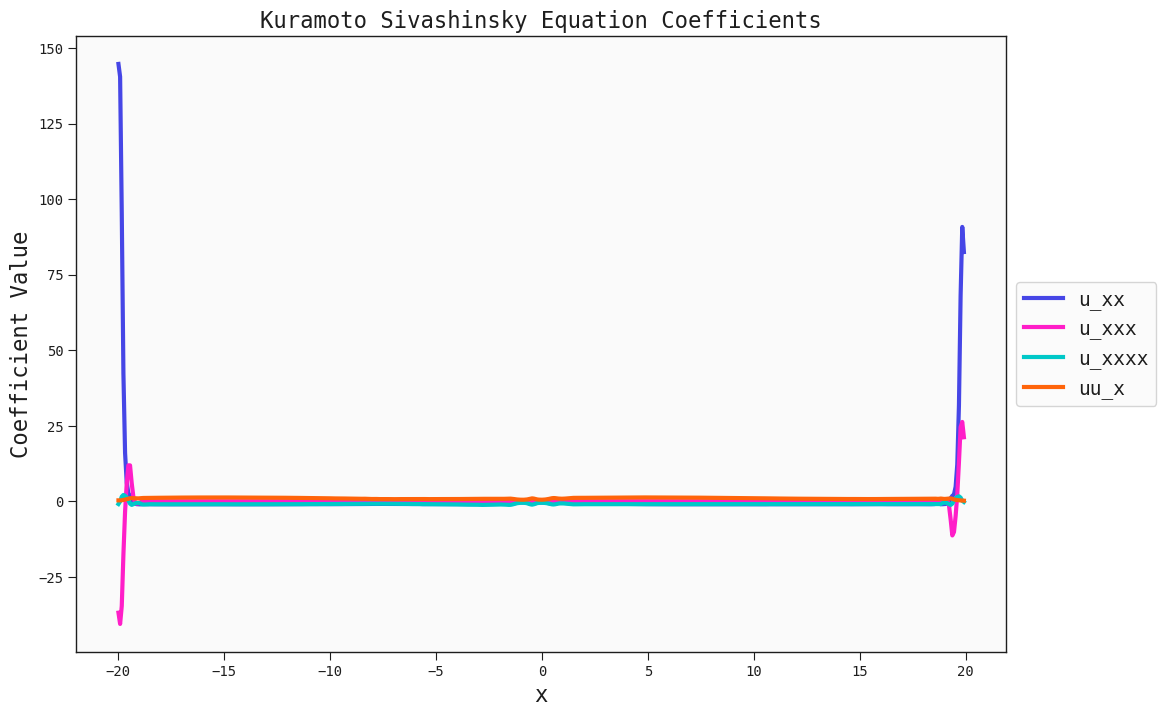

In [9]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.show()
# mse_clean_sgtr = Norm(xi-xi_true[:,wx:-wx])**2/(m*len(rhs_des))
# print('MSE: ', mse_clean_sgtr)

In [10]:
candidates = {(0, 1, 3, 4, 6, 7, 8, 9, 11),
              (0, 1, 3, 4, 6, 7, 10, 11),
              (1, 2, 3, 4, 6, 7, 8, 12, 15, 16),
              (3, 4, 6, 7),
              (3, 4, 6, 7, 9, 10, 11, 13, 14, 15, 18),
              (3, 4, 6, 7, 9, 12),
              (3, 4, 6, 7, 9, 12, 18),
              (3, 4, 6, 7, 13),
              (4, 6, 7),
              (6, 7),
              (7,)}
candidates = sorted(candidates, key=len)
rhs_des[4], rhs_des[6], rhs_des[7]

('u_xx', 'u_xxxx', 'uu_x')

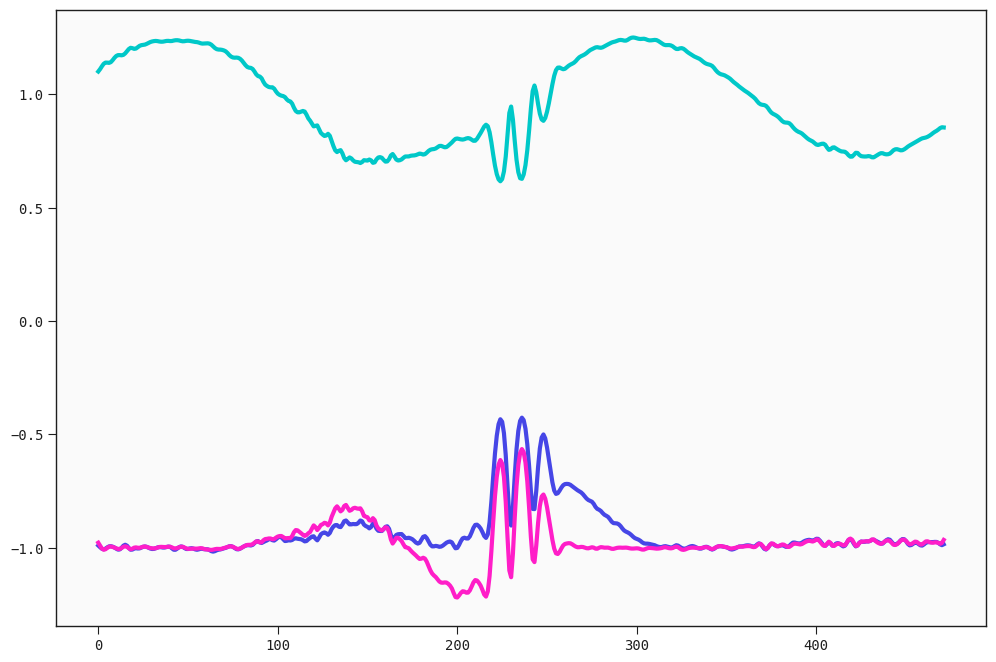

In [11]:
f_u_xx, f_u_xxxx, f_uu_x = linear_fit_grouped_data((Theta_grouped, Ut_grouped), 
                                             considered_indices=candidates[2])
plt.plot(f_u_xx[20:-20])
plt.plot(f_u_xxxx[20:-20])
plt.plot(f_uu_x[20:-20])
plt.show()

#### Feyn

In [12]:
ql = feyn.QLattice()
# w = 20
# train = pd.DataFrame({'x':x[w:-w], 'y':f_u_xx[w:-w]})
win = 31; w = 15
A = x[win-1:][w:-w]
B = pd.Series(f_u_xx).rolling(window=win).mean().iloc[win-1:].values[w:-w]
train = pd.DataFrame({'x':A, 'y':B})
models = ql.auto_run(train, output_name = 'y', max_complexity=2, n_epochs=20)
best1 = models[0]
best1.sympify().as_expr()

-0.976754 + 0.353986*exp(-0.493521*(1 - 0.547288*x)**2)

In [13]:
ql = feyn.QLattice()
# w = 20
# train = pd.DataFrame({'x':x[w:-w], 'y':f_u_xxxx[w:-w]})
win = 16; w = 15
A = x[win-1:][w:-w]
B = pd.Series(f_u_xxxx).rolling(window=win).mean().iloc[win-1:].values[w:-w]
train = pd.DataFrame({'x':A, 'y':B})
models = ql.auto_run(train, output_name = 'y', max_complexity=3, n_epochs=20)
best2 = models[0]
best2.sympify().as_expr()

-0.966723 - 0.249388*exp(-3.73627*(0.429437*x + 1)**2)

In [14]:
est_uu_x = (-0.25113 * sin(x * -0.32253)) + 0.95955
est_u_xx = best1.predict(pd.DataFrame({'x':x}))
est_u_xxxx = best2.predict(pd.DataFrame({'x':x}))

latex(best1.sympify().as_expr(), full_prec=False), latex(best2.sympify().as_expr(), full_prec=False)

('-0.976754 + 0.353986 e^{- 0.493521 \\left(1 - 0.547288 x\\right)^{2}}',
 '-0.966723 - 0.249388 e^{- 3.73627 \\left(0.429437 x + 1\\right)^{2}}')

In [15]:
def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)
coeff_error(est_uu_x, uu_x_true), coeff_error(est_u_xx, u_xx_true), coeff_error(est_u_xxxx, u_4x_true)

(4.055148714858324, 4.0270070463588565, 4.3653505414677465)

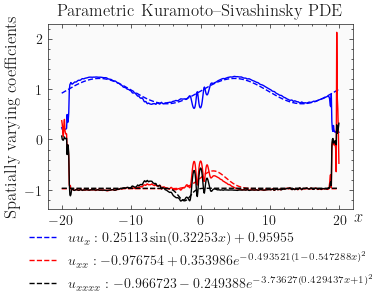

In [16]:
fs = 12
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(x, f_uu_x, '-', c='blue')
    ax.plot(x, est_uu_x, '--', c='blue', label='$uu_{x}: 0.25113\sin(0.32253x) + 0.95955$')
    ax.plot(x, f_u_xx, '-', c='red')
    ax.plot(x, est_u_xx, '--', c='red', label='$u_{xx}: -0.976754 + 0.353986 e^{- 0.493521 \\left(1 - 0.547288 x\\right)^{2}}$')
    ax.plot(x, f_u_xxxx, '-', c='black')
    ax.plot(x, est_u_xxxx, '--', c='black', label='$u_{xxxx}: -0.966723 - 0.249388 e^{- 3.73627 \\left(0.429437 x + 1\\right)^{2}}$')
    ax.set_ylabel('Spatially varying coefficients', fontsize=fs)
    ax.set_xlabel('$x$', fontsize=fs)
    ax.xaxis.set_label_coords(1.02, 0)
    ax.set_title("Parametric Kuramoto–Sivashinsky PDE", fontsize=fs)
    ax.legend(fontsize=fs)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=False, shadow=False, ncol=1)
    fig.tight_layout()
    plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/ks_feyn_noise0-01.pdf")
    plt.show()

#### PySR

In [17]:
y1 = (sin(x * -0.32253) * -0.25117) - -0.95951
y1 = (-0.25113 * sin(x * -0.32253)) + 0.95955

y2 = -0.97764 + (0.2091 * exp(((x - 3.3079) * x) * -0.1777))
# y2 = exp(-2.4803 - ((x + -2.5827) * x)) + -0.95397

y3 = (0.19909 * (exp((x * x) * -0.26832) * x)) + -0.9798
# y3 = y = exp(-1.7509 - (x * x)) + -0.98854

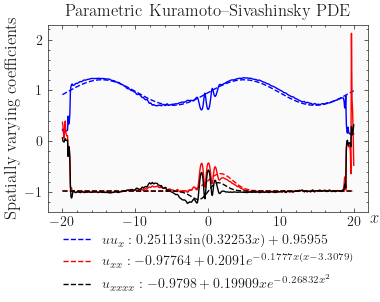

In [18]:
fs = 12
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(x, f_uu_x, '-', c='blue')
    ax.plot(x, y1, '--', c='blue', label='$uu_{x}: 0.25113\sin(0.32253x) + 0.95955$')
    ax.plot(x, f_u_xx, '-', c='red')
    ax.plot(x, y2, '--', c='red', label='$u_{xx}: -0.97764 + 0.2091e^{-0.1777x(x - 3.3079)}$')
    ax.plot(x, f_u_xxxx, '-', c='black')
    ax.plot(x, y3, '--', c='black', label='$u_{xxxx}: - 0.9798 + 0.19909xe^{-0.26832x^{2}}$')
    ax.set_ylabel('Spatially varying coefficients', fontsize=fs)
    ax.set_xlabel('$x$', fontsize=fs)
    ax.xaxis.set_label_coords(1.02, 0)
    ax.set_title("Parametric Kuramoto–Sivashinsky PDE", fontsize=fs)
    ax.legend(fontsize=fs)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=False, shadow=False, ncol=1)
    fig.tight_layout()
    plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/ks_pysr_noise0-01.pdf")
    plt.show()